# Finding a Quality Car
The goal of this program is to segment, visualize, and store quality cars for possible purchase. Data will be routinely taken from craigslist, wrangled, and set through some parameters. The resulting data set will hopefully only be valid matches that can be looked at in greater detail. 
    
    Some of the wrangling problems that are expect to be faced are:
        
        - Duplicate records
        - Fake/spammy records
        - Poorly recorded records
        
        
     The parameters set are:
       
        - Price: $5,000 - $20,000
        - Miles: 0 - 100,000
        - Location: SF Bay Area, LA, Eugene, Portland, Fresno, Sacromento (will expand)



## Loading data & modules

In [2]:
import re
import sklearn
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

%matplotlib inline
sb.set_style('whitegrid')
fig = plt.figure()


#Loading dataset
trucks = pd.read_csv('C:/Users/Scott/Desktop/Data/Tacoma_full_db.csv')

## Cleaning
Here we need to remove:
    - irrelevant features
    - duplicate records
    - fake/spammy records
    - NULL records or columns
Also, we need to:
    - Parse important info from columns
    - Transform columns to their correct data type
    - Create new columns 

#### Removing irrelevant features

In [3]:
del trucks ['Unnamed: 0']
del trucks['has_image']
del trucks['has_map']

#### Removing duplicate records
The only column I can guarantee matched duplicates is 'url'
But I can also assume that if the price and odometer measurements are the same then the records are probably the same.

In [4]:
trucks = trucks.drop_duplicates(['url'])


#### Parsing important information
- Retrieving year from the name column by using RegEx to find '20' and 2 more digits.Importing year into new column.
- Removing the '$' from price to make it a numeric column

In [5]:
year = []

pattern = re.compile(r'\b20\d\d\b')
    
for row in trucks.name:
    s = pattern.search(row)
    if s is None:
        year.append(np.nan)
    else:
        year.append(s.group())

trucks['year'] = year

def remover(s):
    return int(s[1:])
trucks.price = [remover(s) for s in trucks.price]

#### Transforming Columns

In [6]:
trucks['price'] = trucks['price'].astype(float)
trucks ['id'] = trucks.id.astype('str')
pd.set_option('precision',0)


#### New Columns

In [7]:
trucks['man_p*m'] = (trucks.price * trucks.odometer) /100000

There is still alot of wrangling that can be done to clean the data, but for now I will go forward.
- to do:
    - delete fake/spammy
    - Null values

## Exploration

#### Dealing with trucks['drive']
- option 1:
    - delete null values
- other options?

C:\Users\Scott\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


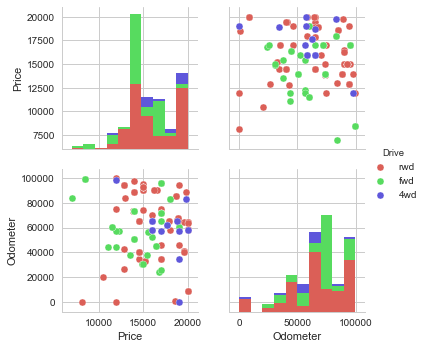

In [8]:
price_and_miles_by_drive = pd.DataFrame((trucks.ix[:,(3,7,9)].values), columns = ['Price','Drive','Odometer'])
price_and_miles_by_drive.Price = price_and_miles_by_drive.Price.astype(int)
price_and_miles_by_drive.Odometer = price_and_miles_by_drive.Odometer.astype(float)
sb.pairplot(price_and_miles_by_drive, hue = 'Drive', palette = 'hls')

Looking at the spread of the drive type against the mileage and pricing
- We see there are very few '4wd', and they are considerably more expensive (> $15,000)
- 'fwd' & 'rwd' both have spreads that might be worth looking into

Price         int32
Drive        object
Odometer    float64
dtype: object


C:\Users\Scott\Anaconda3\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


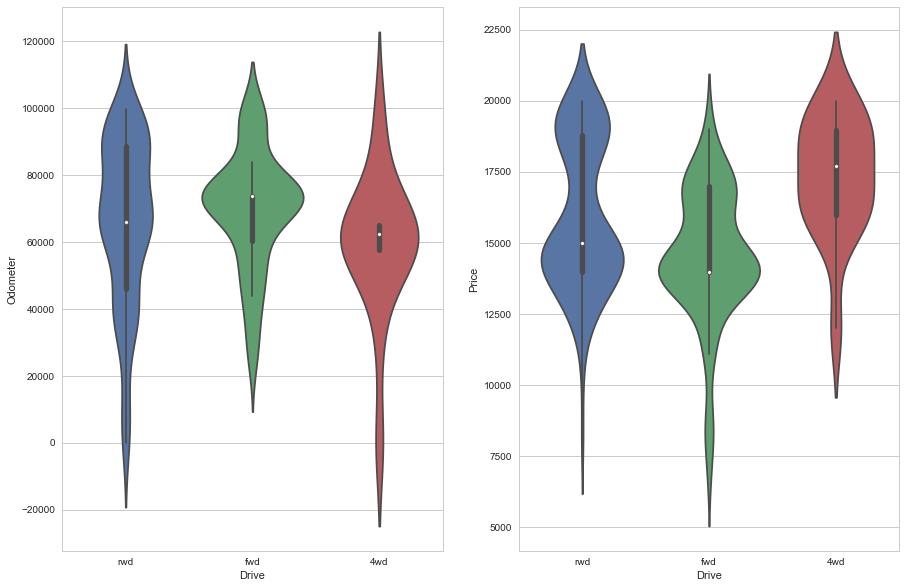

In [9]:
rcParams['figure.figsize'] = 15,10
fig, ax=plt.subplots(1,2)
print(price_and_miles_by_drive.dtypes)
sb.violinplot(x='Drive',y='Odometer',data= price_and_miles_by_drive, ax=ax[0])
sb.violinplot(x='Drive',y='Price',data= price_and_miles_by_drive, ax=ax[1])
fig.show()

A different angle for reference
- ignoring 4wd because of its lack of N
- We see a large bump for both rwd and fwd around the $14,500 mark
- Also, notice that very few trucks are being sold with milegae under 50,000

removing 'drive' nulls and viewing graphs

In [10]:
trucks = trucks[trucks.drive.notnull()] 
trucks = trucks[trucks.year.notnull()]
print(trucks.isnull().sum())
print("")
print(len(trucks.drive))

datetime       0
id             0
name           0
price          0
url            0
where        107
status         0
drive          0
condition     87
odometer       0
year           0
man_p*m        0
dtype: int64

201


Number of fwd: 
72
Number of rwd: 
113
Number of 4wd: 
13


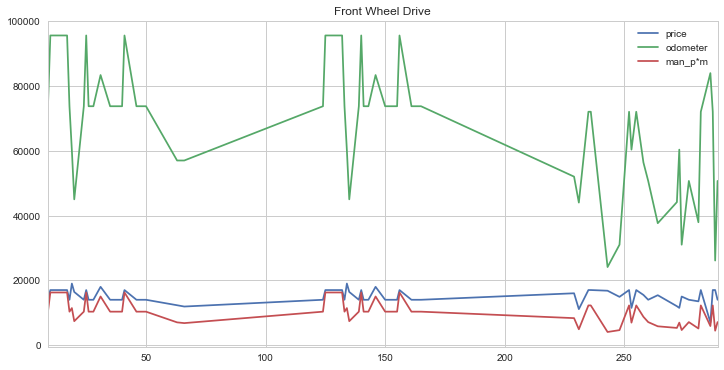

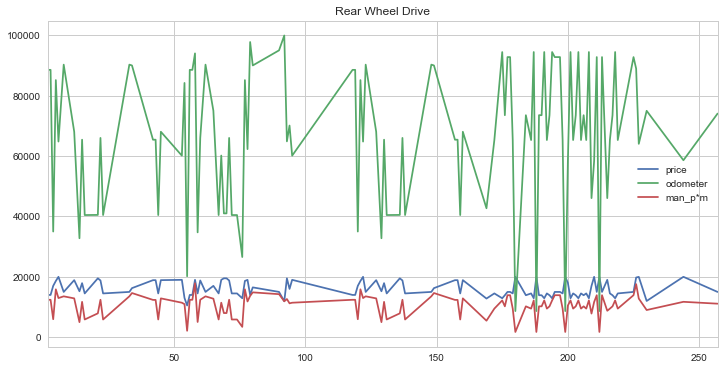

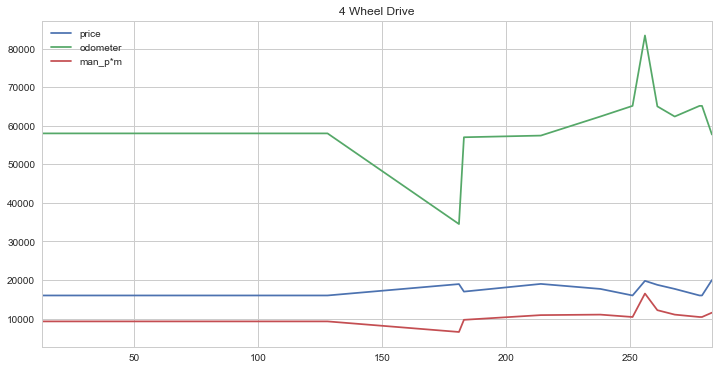

In [11]:
rcParams['figure.figsize'] =12,6
good_trucks = trucks.loc[trucks['price'] > 5000]
good_trucks = good_trucks.loc[good_trucks['odometer'] > 1000]

fwd_trucks = good_trucks.loc[good_trucks.drive == 'fwd']
fwd_trucks.plot()
plt.title('Front Wheel Drive')
print('Number of fwd: ')
print(len(fwd_trucks))

rwd_trucks = good_trucks.loc[good_trucks.drive == 'rwd']
rwd_trucks.plot()
plt.title('Rear Wheel Drive')
print('Number of rwd: ')
print(len(rwd_trucks))

awd_trucks = good_trucks.loc[good_trucks.drive == '4wd']
awd_trucks.plot()
plt.title('4 Wheel Drive')
print('Number of 4wd: ')
print(len(awd_trucks))


Here we look at the spread of each drive type by the index. This might not be a very important graphic because of the lack of detail in price and price*miles. But all angles of the data can help.

## Extract and Save

In [13]:
good_trucks = trucks.loc[trucks['price'] > 5000]
good_trucks = good_trucks.loc[good_trucks['odometer'] > 1000]
quality_trucks = good_trucks.loc[good_trucks['price'] < 15000]
quality_trucks = quality_trucks.loc[quality_trucks['odometer'] < 75000]
print('Number of Quality Trucks')
print(len(quality_trucks))

Number of Quality Trucks
79


Narrowing the parameters which removes all 4wd's

In [14]:
quality_trucks.head()

,datetime,id,name,price,url,where,status,drive,condition,odometer,year,man_p*m
9,2017-09-14 16:45,6306384866,2010 TOYOTA TACOMA - 73K MILES- MANUAL- STOCK#...,13990,http://sfbay.craigslist.org/eby/ctd/d/2010-toy...,concord / pleasant hill / martinez,clean,fwd,excellent,73756,2010,10318
16,2017-09-08 19:42,6298733756,2010 Toyota Tacoma 2WD -Rates low as 2.49% o.a.c.,14495,http://sfbay.craigslist.org/eby/ctd/d/2010-toy...,bayareamotorsports.net,clean,rwd,excellent,40454,2010,5864
18,2017-09-08 19:31,6298725267,2010 TOYOTA TACOMA - 73K MILES- MANUAL- STOCK#...,13990,http://sfbay.craigslist.org/eby/ctd/d/2010-toy...,concord / pleasant hill / martinez,clean,fwd,excellent,73756,2010,10318
23,2017-09-01 17:43,6289775431,2010 Toyota Tacoma 2WD -MUST SEE!,14495,http://sfbay.craigslist.org/eby/ctd/d/2010-toy...,bayareamotorsports.net,clean,rwd,excellent,40454,2010,5864
24,2017-09-01 16:11,6289683935,2010 TOYOTA TACOMA - 73K MILES- MANUAL- STOCK#...,13990,http://sfbay.craigslist.org/eby/ctd/d/2010-toy...,concord / pleasant hill / martinez,clean,fwd,excellent,73756,2010,10318


In [20]:
x = quality_trucks.odometer.tolist()
y = quality_trucks.price.tolist()
indexer = quality_trucks.index.tolist()
c = quality_trucks.drive.loc[quality_trucks['drive'] == 'fwd']

print(len(x),len(y),len(indexer))

79 79 79


In [31]:
def f(x,y,indexer):
    ax = plt.scatter(x,y, c = c, palette = 'hls', fit_reg = False, size = 8)
    for i in enumerate(indexer):
        ax.annotate(str(indexer[i]),fontsize=8,
                textcoords="offset points",
                color=kwargs.get("color","k"), 
                bbox=dict(pad=.9,alpha=0.2, fc='limegreen',color='none'),
                va='center', ha='center',weight='bold')


<function __main__.f>

Scatterplot of all high quality prospects. Data labels show the row number for each scatter point.